# Renat's finance toys

Полезные ссылки:
https://iss.moex.com/iss/reference/
https://iss.moex.com/iss/index
https://iss.moex.com/iss/engines/stock/markets/bonds

https://traderhelper.ru/wiki/

### TODO:
    1. Оценить волатильность и прибыльность портфеля
        a. Таблица строки (Дата, secid1, secid2,... secidn)
        b. Вычислить матрицу корреляций df.corr(method=histogram_intersection)
    2. Жадным алгоритмом собрать портфель с низкой волатильностью, но высокой выгодой
    3. Оценить future spot rates исользуя Фьючерсы

In [79]:
from typing import Union, Any, List, Optional, cast
import requests
import numpy as np
import datetime
import apimoex
import matplotlib
import math
import pandas as pd

OFZ_CODE = "SU26209RMFS5"
ALFA_VENTURE = "RU000A100GW5"
VTB_2022 = "RU000A1031A5"
BOARD = "TQBR"
TAX_RATE = 13/100.0
BROKER_COMISSION = 0.04/100

In [2]:
def per_period_rate_percent(effective_interest_rate:float, times_a_year:float) -> float:
    
    """Returns nominal annual per-period rate (without compouning)
        Parameters
        ----------
        effective_interest_rate : float
            annual effective interest rate, %
        times_a_year : float
            number of compounding periods
        Returns
            ppr, (1+ppr)^times_a_year = 1+eir
    """
    eir = effective_interest_rate/100
    ppr = pow((1+eir),1/times_a_year)-1
    return ppr*100

In [3]:
def eir_to_apr(eir:float, n:float) -> float:
    """Returns nominal annual percentage rate (without compounind)
    Parameters
    ----------
    eir : float
        effective interest rate (annual), %
    times_a_year : float
        number of compounding periods
    Returns
        apr, such that (1+apr/n)^n = 1+eir
    """
    return per_period_rate_percent(eir,n)*n

eir_to_apr(10,12)

9.568968514684517

In [4]:
# [(date, amount, tax),...)
Cashflow = list[tuple[datetime.datetime,float,float]]

In [5]:
def npv_from_cashflow(cashflow : Cashflow,
                      eirp:float,
                     countTax:bool = True) -> float:
    """Returns Net Present Value
    Parameters
    cashflow: [(datetime.datetime.now(),10.0),...]
    eirp: float
        effective annual percent rate, e.g. 5.0 = 5% a year
    """
#     if list is not empty
    if cashflow:
        npv = 0
        now_date = datetime.datetime.combine(datetime.date.today(), datetime.datetime.min.time())
        for (date,CF,tax) in cashflow:
            cash = CF
            if countTax:
                cash -= tax
            if date >= now_date:
                n_years = (date-now_date).days/365.0
#                 discount
                npv += cash/math.pow(1+eirp/100,n_years)
            else:
                print('npv WARNING: cashflow '+str((date,CF,tax))+' is ignored')
        return npv
    else:
        return None

In [6]:
cashflow = [(datetime.datetime(2022,12,1),100,0.0)]
discountingFactor = 8 # %
npv_from_cashflow(cashflow,discountingFactor)

92.98388403605128

In [7]:
def bond_aci(coupon:float,
             times_a_year:float,
             coupondate: datetime.datetime) -> float:
    """ накопленный купонный доход """
    days_to_coupon = (coupondate - datetime.datetime.now()).days
    days_between_coupons = 365.0/times_a_year
    return coupon*(1-days_to_coupon/days_between_coupons)

In [8]:
bond_aci(37.9,2.0,datetime.datetime.fromisoformat('2022-01-19'))

32.08520547945205

In [9]:
def simple_bond_cashflow(bondDict:dict[str,Any]) -> Cashflow:
    """simple bond cashflow taking into account tazws and broker comissions
    Предположения: покупается сейчас,
                    попадает в портфель завтра,
                    держится до погашения номинала,
                    платим налог с каждого купона.
    """
    net_price = bondDict['PRICEP']*(1+BROKER_COMISSION)
    #   режим торгов облигаций T+, то есть сделка только завтра завершится
    tomorrow = datetime.datetime.now()+datetime.timedelta(days=1)
    tax = 0.0
    cashflow = [(tomorrow,-net_price,tax)]
#     накопленный купонный доход
    aci = 0
#     Если еще будут купоны, вычисляем кэшфлоу для них
    coupondate = bondDict['COUPONDATE']
    maturitydate = bondDict['MATDATE']
    times_a_year = bondDict['COUPONFREQUENCY']
    if coupondate is not None:
#       цена купона, в процентах от номинала
        couponp = bondDict['COUPONPERCENT']/times_a_year
#         вычисляем НКД и комиссию брокера с него
        aci = bond_aci(couponp, times_a_year,coupondate)
        net_aci = aci*(1+BROKER_COMISSION)
        buy_aci_date = tomorrow
        aci_tax = 0.0
        cashflow.append((buy_aci_date,-net_aci,aci_tax))
        # время между купонов
        coupon_timedelta = datetime.timedelta(days=365/times_a_year)
        # добавляем каждый купон в кэшфлоу
        cur_date = coupondate
        net_couponp = couponp*(1-BROKER_COMISSION)
        coupon_tax = couponp*TAX_RATE
        #   считаем только на 100 лет вперед
        max_n = 100*int(times_a_year)
        for i in range(max_n):
            if maturitydate is None or (maturitydate - cur_date).days > 0:
                cashflow.append((cur_date,net_couponp,coupon_tax))
                cur_date += coupon_timedelta
            else:
                break
#  если это Consol, то есть бесконечный бонд
    if maturitydate is not None:        
        face = 100 # %
        net_face = face*(1-BROKER_COMISSION)
        tax = 0.0
    #     если облигацию держать меньше 3-х лет, платим налог с погашения
        price = bondDict['PRICEP']
        if (face > price) and (maturitydate-tomorrow).days < 3*365:
    #       заплатим налог. #         При покупке облигаций НКД будет относиться к расходам. А при продаже – к доходам инвестора.
            tax = (face-price)*TAX_RATE
        cashflow.append((maturitydate,net_face,tax))
    return cashflow

In [10]:
def bond_cashflow(bondDict:dict[str,Any]) -> Cashflow: 
    if bondDict['PRICEP'] is None:
        return []
    elif bondDict['TYPE'] == 'SIMPLE' or bondDict['TYPE'] == 'CONSOL':
        return simple_bond_cashflow(bondDict)
    else:
        print('unknown bond type '+bondDict['TYPE'])

In [63]:
def getAnnualStatData(secid:str, session:requests.session) -> dict[str,float]:
    """Get bond price from last trading day
    https://iss.moex.com/iss/history/engines/stock/markets/bonds/securities/SU25083RMFS5?from=2021-12-12
    https://iss.moex.com/iss/history/engines/stock/markets/bonds/securities?from=2021-12-12
    Parameters
        secid: security id
        session: request.Session, HTTP session
    Return
        price in percent
    """
    today = datetime.date.today().strftime("%Y-%m-%d")
    year_ago =  (datetime.date.today() - datetime.timedelta(days = 365)).strftime("%Y-%m-%d")
    price_data = apimoex.get_market_history(session, secid, year_ago, today, ('CLOSE', 'MARKETPRICE3','NUMTRADES'),'bonds', 'stock')
    price_data_frame = pd.DataFrame(price_data)
    mean = price_data_frame['MARKETPRICE3'].mean()
    std = price_data_frame['MARKETPRICE3'].std()
#     last element
    pricep = price_data_frame.loc[price_data_frame.index[-1],'MARKETPRICE3']
    meanNumTrades = price_data_frame['NUMTRADES'].mean()
    return {'PRICEPMEAN':mean,'PRICEPSTD':std,'PRICEP':pricep,'MEANNUMREADES':meanNumTrades}

In [64]:
def downloadBondInfo(secid:str, session:requests.session) -> dict[str,Any]:
    """ Download bond info from moex.com
    """

#     https://iss.moex.com/iss/reference/13
#     https://iss.moex.com/iss/securities/
    data = apimoex.find_security_description(session, secid, ('name', 'title', 'value'))
    # data = Список словарей, которые напрямую конвертируется в pandas.DataFrame
    # создаем датафрейм из 
    df = pd.DataFrame(data)
    df.set_index('name', inplace=True)
    bond_info = {'SECID':df.loc["SECID","value"],
                'NAME':df.loc["NAME","value"],
                'FACEVALUE':np.float64(df.loc["FACEVALUE","value"]),
                'COUPONFREQUENCY':float(df.loc["COUPONFREQUENCY","value"]),
                'COUPONVALUE':0,
                'COUPONPERCENT':0,
                'COUPONDATE':None,
                'MATDATE':None,
                'PRICEP':None}
    if "COUPONVALUE" in df.index:
        bond_info['COUPONVALUE'] = np.float64(df.loc["COUPONVALUE","value"])
    if "COUPONPERCENT" in df.index:
        bond_info['COUPONPERCENT'] = np.float64(df.loc["COUPONPERCENT","value"])
#     next coupon date
    if "COUPONDATE" in df.index:
        bond_info['COUPONDATE'] = datetime.datetime.fromisoformat(df.loc["COUPONDATE","value"])
    if 'MATDATE' in df.index:
        bond_maturity = datetime.datetime.fromisoformat(df.loc["MATDATE","value"])
        bond_info['MATDATE'] = bond_maturity    
        bond_info['TYPE'] = 'SIMPLE'
    else:
        bond_info['TYPE'] = 'CONSOL'
    # now_date = datetime.datetime.combine(datetime.date.today(), datetime.datetime.min.time())
    stat_data = getAnnualStatData(bond_info['SECID'],
                                  session)
    bond_info.update(stat_data)
    # if bond_info['TYPE'] == 'CONSOL' or (bond_maturity - datetime.datetime.now()).days >= 0:
    #     bondPricePercent = getBondPricePercent(bond_info['SECID'],session)
    #     if bondPricePercent is not None:
    #         bond_info['PRICE'] = bond_info['FACEVALUE']*bondPricePercent/100
    return bond_info
    #     Получить историю по одной бумаге на рынке для всех режимов торгов за интервал дат.


In [65]:
with requests.Session() as session:
    ofzDict = downloadBondInfo(OFZ_CODE,session)
    alfaDict = downloadBondInfo(ALFA_VENTURE,session)

In [66]:
def bond_npv(isin:str, discouning_percent:float, session = None) -> float:
    npv = None
    if session is not None:
        npv = npv_from_cashflow(bond_cashflow(downloadBondInfo(isin,session)),discouning_percent)
    else:
        with requests.Session() as session:
            npv = npv_from_cashflow(bond_cashflow(downloadBondInfo(isin,session)),
                                    discouning_percent)            
    return npv

In [67]:
bond_npv('SU26209RMFS5',8.5)

-4.493354530366929

In [68]:
bond_npv('SU26209RMFS5',1)

-0.464127942637802

In [69]:
downloadBondInfo('SU26209RMFS5',session)

{'SECID': 'SU26209RMFS5',
 'NAME': 'ОФЗ-ПД 26209 20/07/22',
 'FACEVALUE': 1000.0,
 'COUPONFREQUENCY': 2.0,
 'COUPONVALUE': 37.9,
 'COUPONPERCENT': 7.6,
 'COUPONDATE': datetime.datetime(2022, 1, 19, 0, 0),
 'MATDATE': datetime.datetime(2022, 7, 20, 0, 0),
 'PRICEP': 99.882,
 'TYPE': 'SIMPLE',
 'PRICEPMEAN': 101.86417254901961,
 'PRICEPSTD': 1.633136157908182,
 'MEANNUMREADES': 968.0509803921568}

In [70]:
bond_cashflow(downloadBondInfo('SU26209RMFS5',session))

[(datetime.datetime(2021, 12, 22, 15, 6, 59, 156039), -99.9219528, 0.0),
 (datetime.datetime(2021, 12, 22, 15, 6, 59, 156039),
  -3.2182730958904107,
  0.0),
 (datetime.datetime(2022, 1, 19, 0, 0), 3.79848, 0.494),
 (datetime.datetime(2022, 7, 20, 0, 0),
  99.96000000000001,
  0.01533999999999935)]

In [71]:
npv_from_cashflow(bond_cashflow(downloadBondInfo('SU26209RMFS5',session)),8.5)

-4.493354530366929

In [72]:
# def find_simple_ofz(session:requests.session) -> pd.DataFrame:
#     data = apimoex.
with requests.Session() as session:
    url = "https://iss.moex.com/iss/securities.json"
    query = {'is_trading':'1','q':'ОФЗ-ПД','securities.columns':'secid'}
    data = (apimoex.ISSClient(session, url, query).get())['securities']
    df = pd.DataFrame(data)
    for idx, row in df.iterrows():
        secid = row['secid']
        try:
            bondInfo = downloadBondInfo(secid,session)
            for key, value in bondInfo.items():
                df.loc[idx,key] = value
        except KeyError as ke:
            print('error secid:',secid)
            print(ke)
        except TypeError as te:
            print('error secid:',secid)
            print(te)

In [88]:
r_percent = 8.5 # %
for idx, row in df.iterrows():
    secid = row['secid']
    # print(row)
    bond_info = {'TYPE':row['TYPE'],
            'FACEVALUE':row['FACEVALUE'],
            'COUPONVALUE':row['COUPONVALUE'],
            'COUPONPERCENT':row['COUPONPERCENT'],
            'COUPONFREQUENCY':row['COUPONFREQUENCY'],
            'COUPONDATE':row['COUPONDATE'],
            'PRICEP':row['PRICEP'],
            'PRICEPSTD':row['PRICEPSTD'],
            'MEANNUMREADES':row['MEANNUMREADES'],
            'MATDATE':row['MATDATE']} 
    bond_npv = npv_from_cashflow(bond_cashflow(bond_info),
                                 r_percent,
                                countTax=False)
    df.loc[idx,'npv'] = bond_npv
sorted_df = df.sort_values(by='npv',ascending=False)
print(sorted_df.loc[:,['secid','PRICEP','npv','PRICEPSTD','MEANNUMREADES','MATDATE']])

           secid   PRICEP       npv  PRICEPSTD  MEANNUMREADES    MATDATE
7   SU26234RMFS3   88.055 -1.376544   2.451483     659.072797 2025-07-16
27  SU26236RMFS8   86.974 -1.517854   3.446953      97.296992 2028-05-17
24  SU26237RMFS6   91.002 -1.577668   3.228273     170.643357 2029-03-14
22  SU26232RMFS7   89.199 -1.614706   3.452069     257.674510 2027-10-06
21  SU26235RMFS0   84.954 -1.764357   3.885858     208.135338 2031-03-12
11  SU26233RMFS5   82.947 -1.860280   3.875943     997.803030 2035-07-18
18  SU26212RMFS9   93.726 -1.879442   3.826465     361.875000 2028-01-19
25  SU26240RMFS0   89.724 -1.880263   3.661272     160.628571 2036-07-30
26  SU26239RMFS2   91.016 -1.889777   3.365351     143.779221 2031-07-23
17  SU26225RMFS1   92.562 -2.096550   4.240876     362.476562 2034-05-10
23  SU26238RMFS4   89.669 -2.100057   3.935142     269.659420 2041-05-15
5   SU26229RMFS3   95.757 -2.238222   3.320222     269.360465 2025-11-12
19  SU26221RMFS0   96.242 -2.299024   4.332584     

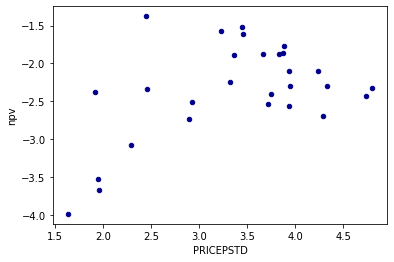

In [89]:
ax1 = sorted_df.plot.scatter(x='PRICEPSTD',
                             y='npv',
                             c='DarkBlue')